<a target="_blank" href="https://colab.research.google.com/github/gox6/colab-demos/blob/main/practical-examples/jump-into-lcel-and-runnables.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The code for the Medium article: [The Practical Example: Jump into LCEL and Runnables](https://medium.com/@jgrygolec/the-practical-example-jump-into-lcel-and-runnables-39eb3596cca1)

# Project Setup

In [1]:
# Installing Python packages & hiding
!apt-get install -q libgraphviz-dev 1> /dev/null # Only required on Colab to iinstal pygraphviz

!pip install --quiet \
  grandalf \
  langchain \
  langchain-openai \
  pygraphviz \
  1> /dev/null

In [251]:
# Importing the packages
import getpass
from operator import itemgetter
import os


from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
    RunnableSequence,
    ConfigurableField
)
from langchain_openai import ChatOpenAI
from langchain.output_parsers.openai_tools import JsonOutputToolsParser

In [3]:
# Managing secrets
# - If using Colab please use Colab Secrets
# - If running outside Colab please provide secrets as environmental variables
COLAB = os.getenv("COLAB_RELEASE_TAG") is not None

if COLAB:
  from google.colab import userdata, data_table
  # Secrets
  OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
  os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
  runtime_info = "Colab runtime"

  # Enabling Colab's data formatter for pandas
  data_table.enable_dataframe_formatter()
elif OPENAI_API_KEY := os.environ.get('OPENAI_API_KEY'):
  # Secrets
  runtime_info = "Non Colab runtime"
else:
  OPENAI_API_KEY = getpass("OPENAI_API_KEY")
  os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
  runtime_info = "Non Colab runtime"

print(runtime_info)

Colab runtime


# Simple Chain in LCEL

In [4]:
# Defining a chain with LCEL
prompt = ChatPromptTemplate.from_template(
    "Provide a definition of the term: {term}"
)
output_parser = StrOutputParser()
model = ChatOpenAI(model="gpt-3.5-turbo")

chain = prompt | model | output_parser


chain.invoke("evolution")

# Output:
# Evolution is the process through which species of organisms
# change over time, typically through genetic variation,
# natural selection, and adaptation to their environment,
# resulting in the development of new species. It is a
# fundamental principle of biology and explains the diversity
# of life on Earth.

'Evolution is the process through which species of organisms change over time, typically through genetic variation, natural selection, and adaptation to their environment, resulting in the development of new species. It is a fundamental principle of biology and explains the diversity of life on Earth.'

In [65]:
# The simplest way to draw the chain as a graph
chain.get_graph().print_ascii()

# Output:
#      +-------------+
#      | PromptInput |
#      +-------------+
#             *
#             *
#             *
#   +--------------------+
#   | ChatPromptTemplate |
#   +--------------------+
#             *
#             *
#             *
#       +------------+
#       | ChatOpenAI |
#       +------------+
#             *
#             *
#             *
#    +-----------------+
#    | StrOutputParser |
#    +-----------------+
#             *
#             *
#             *
# +-----------------------+
# | StrOutputParserOutput |
# +-----------------------+

     +-------------+       
     | PromptInput |       
     +-------------+       
            *              
            *              
            *              
  +--------------------+   
  | ChatPromptTemplate |   
  +--------------------+   
            *              
            *              
            *              
      +------------+       
      | ChatOpenAI |       
      +------------+       
            *              
            *              
            *              
   +-----------------+     
   | StrOutputParser |     
   +-----------------+     
            *              
            *              
            *              
+-----------------------+  
| StrOutputParserOutput |  
+-----------------------+  


In [63]:
# Inspecting chain' input schema
chain.input_schema().schema()

# Output:
# {'title': 'PromptInput',
#  'type': 'object',
#  'properties': {'term': {'title': 'Term', 'type': 'string'}}}

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'term': {'title': 'Term', 'type': 'string'}}}

In [64]:
# Inspecting chain' output schema
chain.output_schema().schema()

# Output:
# {'title': 'StrOutputParserOutput', 'type': 'string'}

{'title': 'StrOutputParserOutput', 'type': 'string'}

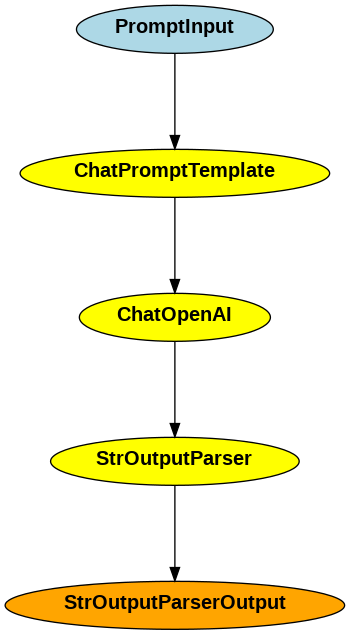

In [57]:
# Drawing a chain in colors
# For more advanced options to draw chains see:
# https://github.com/langchain-ai/langgraph/blob/main/examples/visualization.ipynb
from IPython.display import Image
Image(chain.get_graph().draw_png())

# Examples of LCEL primitives

In [96]:
runnable_passthrough = RunnablePassthrough()
runnable_passthrough.invoke({"greeting": "Hello World!"})

# Output:
# {'greeting': 'Hello World!'}

{'greeting': 'Hello World!'}

In [98]:
runnable_sequence = RunnableSequence(
    RunnablePassthrough(),
    RunnablePassthrough()
)
runnable_sequence

# Output:
# RunnablePassthrough()
# | RunnablePassthrough()

RunnablePassthrough()
| RunnablePassthrough()

In [85]:
runnable_sequence.invoke({'greeting': 'Hello World!'})

# Output:
# {'greeting': 'Hello World!'}

{'greeting': 'Hello World!'}

In [91]:
runnable_parallel = RunnableParallel(
    first=RunnablePassthrough(),
    second=RunnablePassthrough()
)
runnable_parallel

# Output:
# {
#   first: RunnablePassthrough(),
#   second: RunnablePassthrough()
# }

{
  first: RunnablePassthrough(),
  second: RunnablePassthrough()
}

In [94]:
runnable_parallel_alt = RunnableParallel(
    {
    "first": RunnablePassthrough(),
    "second": RunnablePassthrough()
    }
)
runnable_parallel_alt

# Output:
# {
#   first: RunnablePassthrough(),
#   second: RunnablePassthrough()
# }

{
  first: RunnablePassthrough(),
  second: RunnablePassthrough()
}

In [101]:
runnable_lambda = RunnableLambda(lambda x: x + 1)
runnable_lambda.invoke(1)

# Output:
# 2

2

In [109]:
runnable_lambda = itemgetter("a") | RunnableLambda(lambda x: x + 1)
runnable_lambda.invoke({"a": 1, "b": -1})

# Output:
# 2

2

In [163]:
runnable_passthrough_assign = RunnablePassthrough.assign(c=lambda x: x["a"]+2)
runnable_passthrough_assign.invoke({"a": 1})

# Output:
# {'a': 1, 'c': 3}

{'a': 1, 'c': 3}

In [269]:
from langchain_core.runnables import ConfigurableField
from langchain_openai import ChatOpenAI

model_with_temperature = ChatOpenAI(temperature=0).configurable_fields(
    temperature=ConfigurableField(
        id="llm_temperature",
        name="LLM Temperature",
        description="The temperature of the LLM",
    )
)

chain_with_temperature = model_with_temperature | output_parser

(
    chain_with_temperature
        .with_config(configurable={"llm_temperature": 0})
        .invoke("Choose a radnom word")
)

# Output
# Elephant

'Elephant'

In [ ]:
llm = ChatAnthropic(temperature=0).configurable_alternatives(
    # This gives this field an id
    # When configuring the end runnable, we can then use this id to configure this field
    ConfigurableField(id="llm"),
    # This sets a default_key.
    # If we specify this key, the default LLM (ChatAnthropic initialized above) will be used
    default_key="anthropic",
    # This adds a new option, with name `openai` that is equal to `ChatOpenAI()`
    openai=ChatOpenAI(),
    # This adds a new option, with name `gpt4` that is equal to `ChatOpenAI(model="gpt-4")`
    gpt4=ChatOpenAI(model="gpt-4"),
    # You can add more configuration options here
)
prompt = PromptTemplate.from_template("Tell me a joke about {topic}")
chain = prompt | llm

In [258]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser

tools = [
    {
        "type": "function",
        "function": {
            "name": "calculate",
            "description": "Compute the arithmetic equation",
            "parameters": {
                "type": "object",
                "properties": {
                    "equation": {
                        "type": "string",
                        "description": "Arithmetic equation expressed in natural language",
                    },
                    "solution": {
                    "type": "string",
                    "description": "The solution to the equation",
                        },
                },

                "required": ["equation", "solution"],
            },
        },
    }
]


openai_parser = JsonOutputToolsParser()
model_with_tools = ChatOpenAI(model="gpt-3.5-turbo",
                              temperature=0).bind(tools=tools)
calculator_chain = model_with_tools | openai_parser

calculator_chain.invoke("1 plus 8 and then take the sum to power 2")

# Output
# [{'args': {'equation': '1 + 8 = 9, then 9 ^ 2 = 81', 'solution': '81'},
#   'type': 'calculate'}]

[{'args': {'equation': '1 + 8 = 9, then 9 ^ 2 = 81', 'solution': '81'},
  'type': 'calculate'}]